[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# How to Train YOLOv5 on Custom Objects

**⚠️ This notebook was updated on October 24th, 2023. Since then, the way to load data into the notebook has changed. Thus, this notebook is not the same as the original version used in the accompanying YouTube video or blog post.**

This tutorial is based on the [YOLOv5 repository](https://github.com/ultralytics/yolov5) by [Ultralytics](https://www.ultralytics.com/). This notebook shows training on **your own custom objects**. Many thanks to Ultralytics for putting this repository together - we hope that in combination with clean data management tools at Roboflow, this technologoy will become easily accessible to any developer wishing to use computer vision in their projects.

### Accompanying Blog Post

We recommend that you follow along in this notebook while reading the blog post on [how to train YOLOv5](https://blog.roboflow.ai/how-to-train-yolov5-on-a-custom-dataset/), concurrently.

### Steps Covered in this Tutorial

In this tutorial, we will walk through the steps required to train YOLOv5 on your custom objects. We use a [public blood cell detection dataset](https://public.roboflow.ai/object-detection/bccd), which is open source and free to use. You can also use this notebook on your own data.

To train our detector we take the following steps:

* Install YOLOv5 dependencies
* Download custom YOLOv5 object detection data
* Write our YOLOv5 Training configuration
* Run YOLOv5 training
* Evaluate YOLOv5 performance
* Visualize YOLOv5 training data
* Run YOLOv5 inference on test images
* Export saved YOLOv5 weights for future inference

Let's get started!

#Install Dependencies

_(Remember to choose GPU in Runtime if not already selected. Runtime --> Change Runtime Type --> Hardware accelerator --> GPU)_

In [1]:
DATASET_VERSION = 15

In [2]:
# clone YOLOv5 repository
!git clone https://github.com/ultralytics/yolov5  # clone repo
%cd yolov5
!git reset --hard 064365d8683fd002e9ad789c1e91fa3d021b44f0

Cloning into 'yolov5'...


remote: Enumerating objects: 16114, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 16114 (delta 8), reused 10 (delta 1), pack-reused 16089
Receiving objects: 100% (16114/16114), 14.79 MiB | 13.14 MiB/s, done.
Resolving deltas: 100% (11032/11032), done.
/calorie/Ipynb_Files/yolov5
HEAD is now at 064365d Update parse_opt() in export.py to work as in train.py (#10789)


In [3]:
# install dependencies as necessary
!pip install -qr requirements.txt  # install dependencies (ignore errors)
import torch

from IPython.display import Image, clear_output  # to display images
from utils.downloads import attempt_download  # to download models/datasets

# clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

Setup complete. Using torch 2.1.2+cu121 _CudaDeviceProperties(name='NVIDIA GeForce RTX 3060', major=8, minor=6, total_memory=12044MB, multi_processor_count=28)


## Roboflow Universe

Need data for your project? Before spending time on annotating, check out Roboflow Universe, a repository of more than 200,000 open-source datasets that you can use in your projects. You'll find datasets containing everything from annotated cracks in concrete to plant images with disease annotations.


[![Roboflow Universe](https://media.roboflow.com/notebooks/template/uni-banner-frame.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672878480290)](https://universe.roboflow.com/)

## Preparing a custom dataset

Building a custom dataset can be a painful process. It might take dozens or even hundreds of hours to collect images, label them, and export them in the proper format. Fortunately, Roboflow makes this process as straightforward and fast as possible. Let me show you how!

### Step 1: Creating project

Before you start, you need to create a Roboflow [account](https://app.roboflow.com/login). Once you do that, you can create a new project in the Roboflow [dashboard](https://app.roboflow.com/). Keep in mind to choose the right project type. In our case, Object Detection.

<div align="center">
  <img
    width="640"
    src="https://media.roboflow.com/preparing-custom-dataset-example/creating-project.gif?ik-sdk-version=javascript-1.4.3&updatedAt=1672929799852"
  >
</div>

### Step 2: Uploading images

Next, add the data to your newly created project. You can do it via API or through our [web interface](https://docs.roboflow.com/adding-data/object-detection).

If you drag and drop a directory with a dataset in a supported format, the Roboflow dashboard will automatically read the images and annotations together.

<div align="center">
  <img
    width="640"
    src="https://media.roboflow.com/preparing-custom-dataset-example/uploading-images.gif?ik-sdk-version=javascript-1.4.3&updatedAt=1672929808290"
  >
</div>

### Step 3: Labeling

If you only have images, you can label them in [Roboflow Annotate](https://docs.roboflow.com/annotate).

<div align="center">
  <img
    width="640"
    src="https://user-images.githubusercontent.com/26109316/210901980-04861efd-dfc0-4a01-9373-13a36b5e1df4.gif"
  >
</div>

### Step 4: Generate new dataset version

Now that we have our images and annotations added, we can Generate a Dataset Version. When Generating a Version, you may elect to add preprocessing and augmentations. This step is completely optional, however, it can allow you to significantly improve the robustness of your model.

<div align="center">
  <img
    width="640"
    src="https://media.roboflow.com/preparing-custom-dataset-example/generate-new-version.gif?ik-sdk-version=javascript-1.4.3&updatedAt=1673003597834"
  >
</div>

### Step 5: Exporting dataset

Once the dataset version is generated, we have a hosted dataset we can load directly into our notebook for easy training. Click `Export` and select the `YOLO v5 PyTorch` dataset format.

<div align="center">
  <img
    width="640"
    src="https://media.roboflow.com/preparing-custom-dataset-example/export.gif?ik-sdk-version=javascript-1.4.3&updatedAt=1672943313709"
  >
</div>


## Step 6: Download a Dataset

Add your Roboflow API key below to download the default money counting dataset. Alternatively, use the code provided by the Roboflow dashboard in the above step to load a custom dataset.

In [4]:
%pwd

'/calorie/Ipynb_Files/yolov5'

In [5]:
!pip install -q roboflow

#%cd ./yolov5
from roboflow import Roboflow
rf = Roboflow(api_key="lttzJNap0h9lODifvr4O")
project = rf.workspace("school-yrws4").project("food-pion4")
dataset = project.version(DATASET_VERSION).download("yolov5")
#%cd ./yolov5
%pwd

loading Roboflow workspace...
loading Roboflow project...
Exporting format yolov5pytorch in progress : 85.0%
Version export complete for yolov5pytorch format



Extracting Dataset Version Zip to Food-15 in yolov5pytorch:: 100%|██████████| 9020/9020 [00:02<00:00, 3454.00it/s]


'/calorie/Ipynb_Files/yolov5'

In [6]:
# this is the YAML file Roboflow wrote for us that we're loading into this notebook with our data
%cat {dataset.location}/data.yaml

names:
- Kabayaki sea bream fillet
- Spam
- apple -sliced-
- bean sprouts
- braised pork
- cabbage
- cauliflower
- cherry tomato
- coin
- creamy tofu
- creamy tofu -without sauce-
- cucumber
- dragon fruit
- egg tofu
- eggplant
- firm tofu
- fish cake
- fried chicken cutlet
- fried potato
- fried tofu
- green bean
- guava -sliced-
- mushroom
- mustard greens
- omelette
- onion
- pig blood curd
- pig liver
- pineapple
- pumpkin
- red braised pork
- soy egg
- sponge gourd
- steamed egg
- stir fried eggplant
- sweet and sour pork
- sweet potato
- sweet potato leaves
- tangerine
- wax apple
nc: 40
roboflow:
  license: CC BY 4.0
  project: food-pion4
  url: https://universe.roboflow.com/school-yrws4/food-pion4/dataset/15
  version: 15
  workspace: school-yrws4
test: ../test/images
train: Food-15/train/images
val: Food-15/valid/images


# Define Model Configuration and Architecture

We will write a yaml script that defines the parameters for our model like the number of classes, anchors, and each layer.

You do not need to edit these cells, but you may.

In [7]:
# define number of classes based on YAML
import yaml
with open(dataset.location + "/data.yaml", 'r') as stream:
    num_classes = str(yaml.safe_load(stream)['nc'])

In [8]:
#this is the model configuration we will use for our tutorial
%cat ./models/yolov5s.yaml

# YOLOv5 🚀 by Ultralytics, GPL-3.0 license

# Parameters
nc: 80  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]]

In [9]:
#customize iPython writefile so we can write variables
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [10]:
%%writetemplate ./models/custom_yolov5s.yaml

# parameters
nc: {num_classes}  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, BottleneckCSP, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, BottleneckCSP, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, BottleneckCSP, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, BottleneckCSP, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, BottleneckCSP, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

In [11]:
#AttributeError: 'FreeTypeFont' object has no attribute 'getsize'
#https://github.com/ultralytics/yolov5/issues/11838
!pip uninstall Pillow -y
!pip install Pillow==9.4.0

Found existing installation: Pillow 9.4.0
Uninstalling Pillow-9.4.0:
  Successfully uninstalled Pillow-9.4.0


  Using cached Pillow-9.4.0-cp310-cp310-manylinux_2_28_x86_64.whl (3.4 MB)


# Train Custom YOLOv5 Detector

### Next, we'll fire off training!


Here, we are able to pass a number of arguments:
- **img:** define input image size
- **batch:** determine batch size
- **epochs:** define the number of training epochs. (Note: often, 3000+ are common here!)
- **data:** set the path to our yaml file
- **cfg:** specify our model configuration
- **weights:** specify a custom path to weights. (Note: you can download weights from the Ultralytics Google Drive [folder](https://drive.google.com/open?id=1Drs_Aiu7xx6S-ix95f9kNsA6ueKRpN2J))
- **name:** result names
- **nosave:** only save the final checkpoint
- **cache:** cache images for faster training

In [12]:
%%time
# train yolov5s on custom data for 100 epochs
# time its performance
#%cd /content/yolov5/
!python train.py --img 640 --batch 32 --epochs 1000 --data {dataset.location}/data.yaml --cfg ./models/custom_yolov5s.yaml --weights '' --name yolov5s_results  --cache

train: weights=, cfg=./models/custom_yolov5s.yaml, data=/calorie/Ipynb_Files/yolov5/Food-15/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=1000, batch_size=32, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=yolov5s_results, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: ⚠️ YOLOv5 is out of date by 181 commits. Use `git pull` or `git clone https://github.com/ultralytics/yolov5` to update.
YOLOv5 🚀 v7.0-72-g064365d Python-3.10.13 torch-2.1.2+cu121 CUDA:0 (NVIDIA GeForce RTX 3060, 12044MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, war

# Evaluate Custom YOLOv5 Detector Performance

You can view the training graphs associated with a training job in the `/content/yolov5/runs/train/yolov5s_results/results.png` folder.

Training losses and performance metrics are also saved to Tensorboard and also to a logfile defined above with the **--name** flag when we train. In our case, we named this `yolov5s_results`.

Note from Glenn: Partially completed `results.txt` files can be plotted with `from utils.utils import plot_results; plot_results()`.

In [13]:
#%cd ..

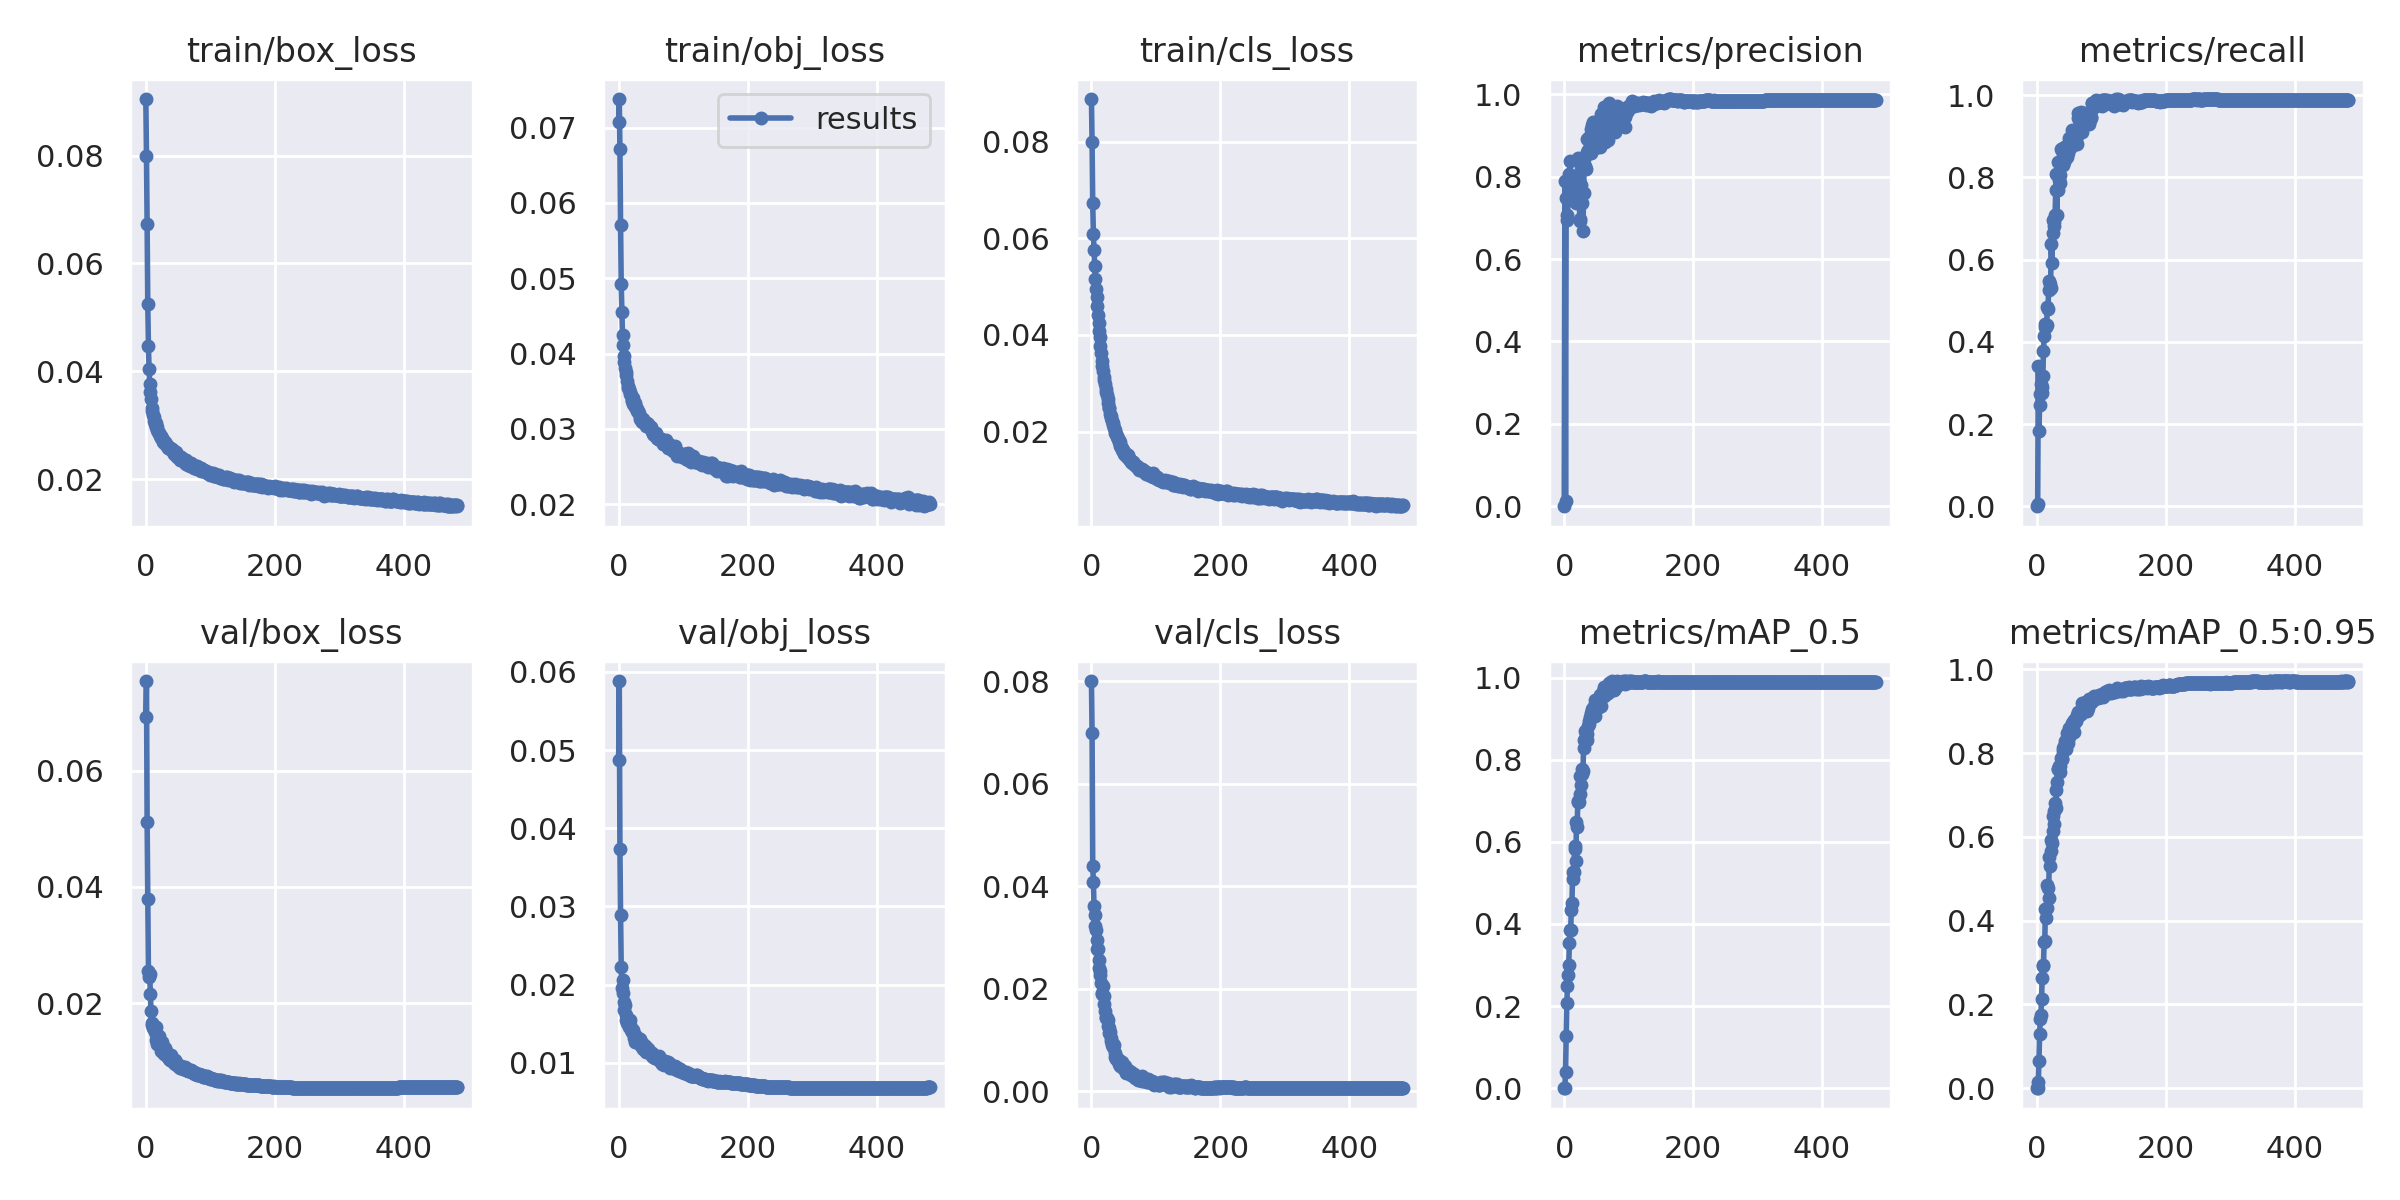

In [14]:
from utils.plots import plot_results  # plot results.txt as results.png
Image(filename='./runs/train/yolov5s_results/results.png', width=1000)  # view results.png

### Curious? Visualize Our Training Data with Labels

After training starts, view `train*.jpg` images to see training images, labels and augmentation effects.

Note a mosaic dataloader is used for training (shown below), a new dataloading concept developed by Glenn Jocher and first featured in [YOLOv4](https://arxiv.org/abs/2004.10934).

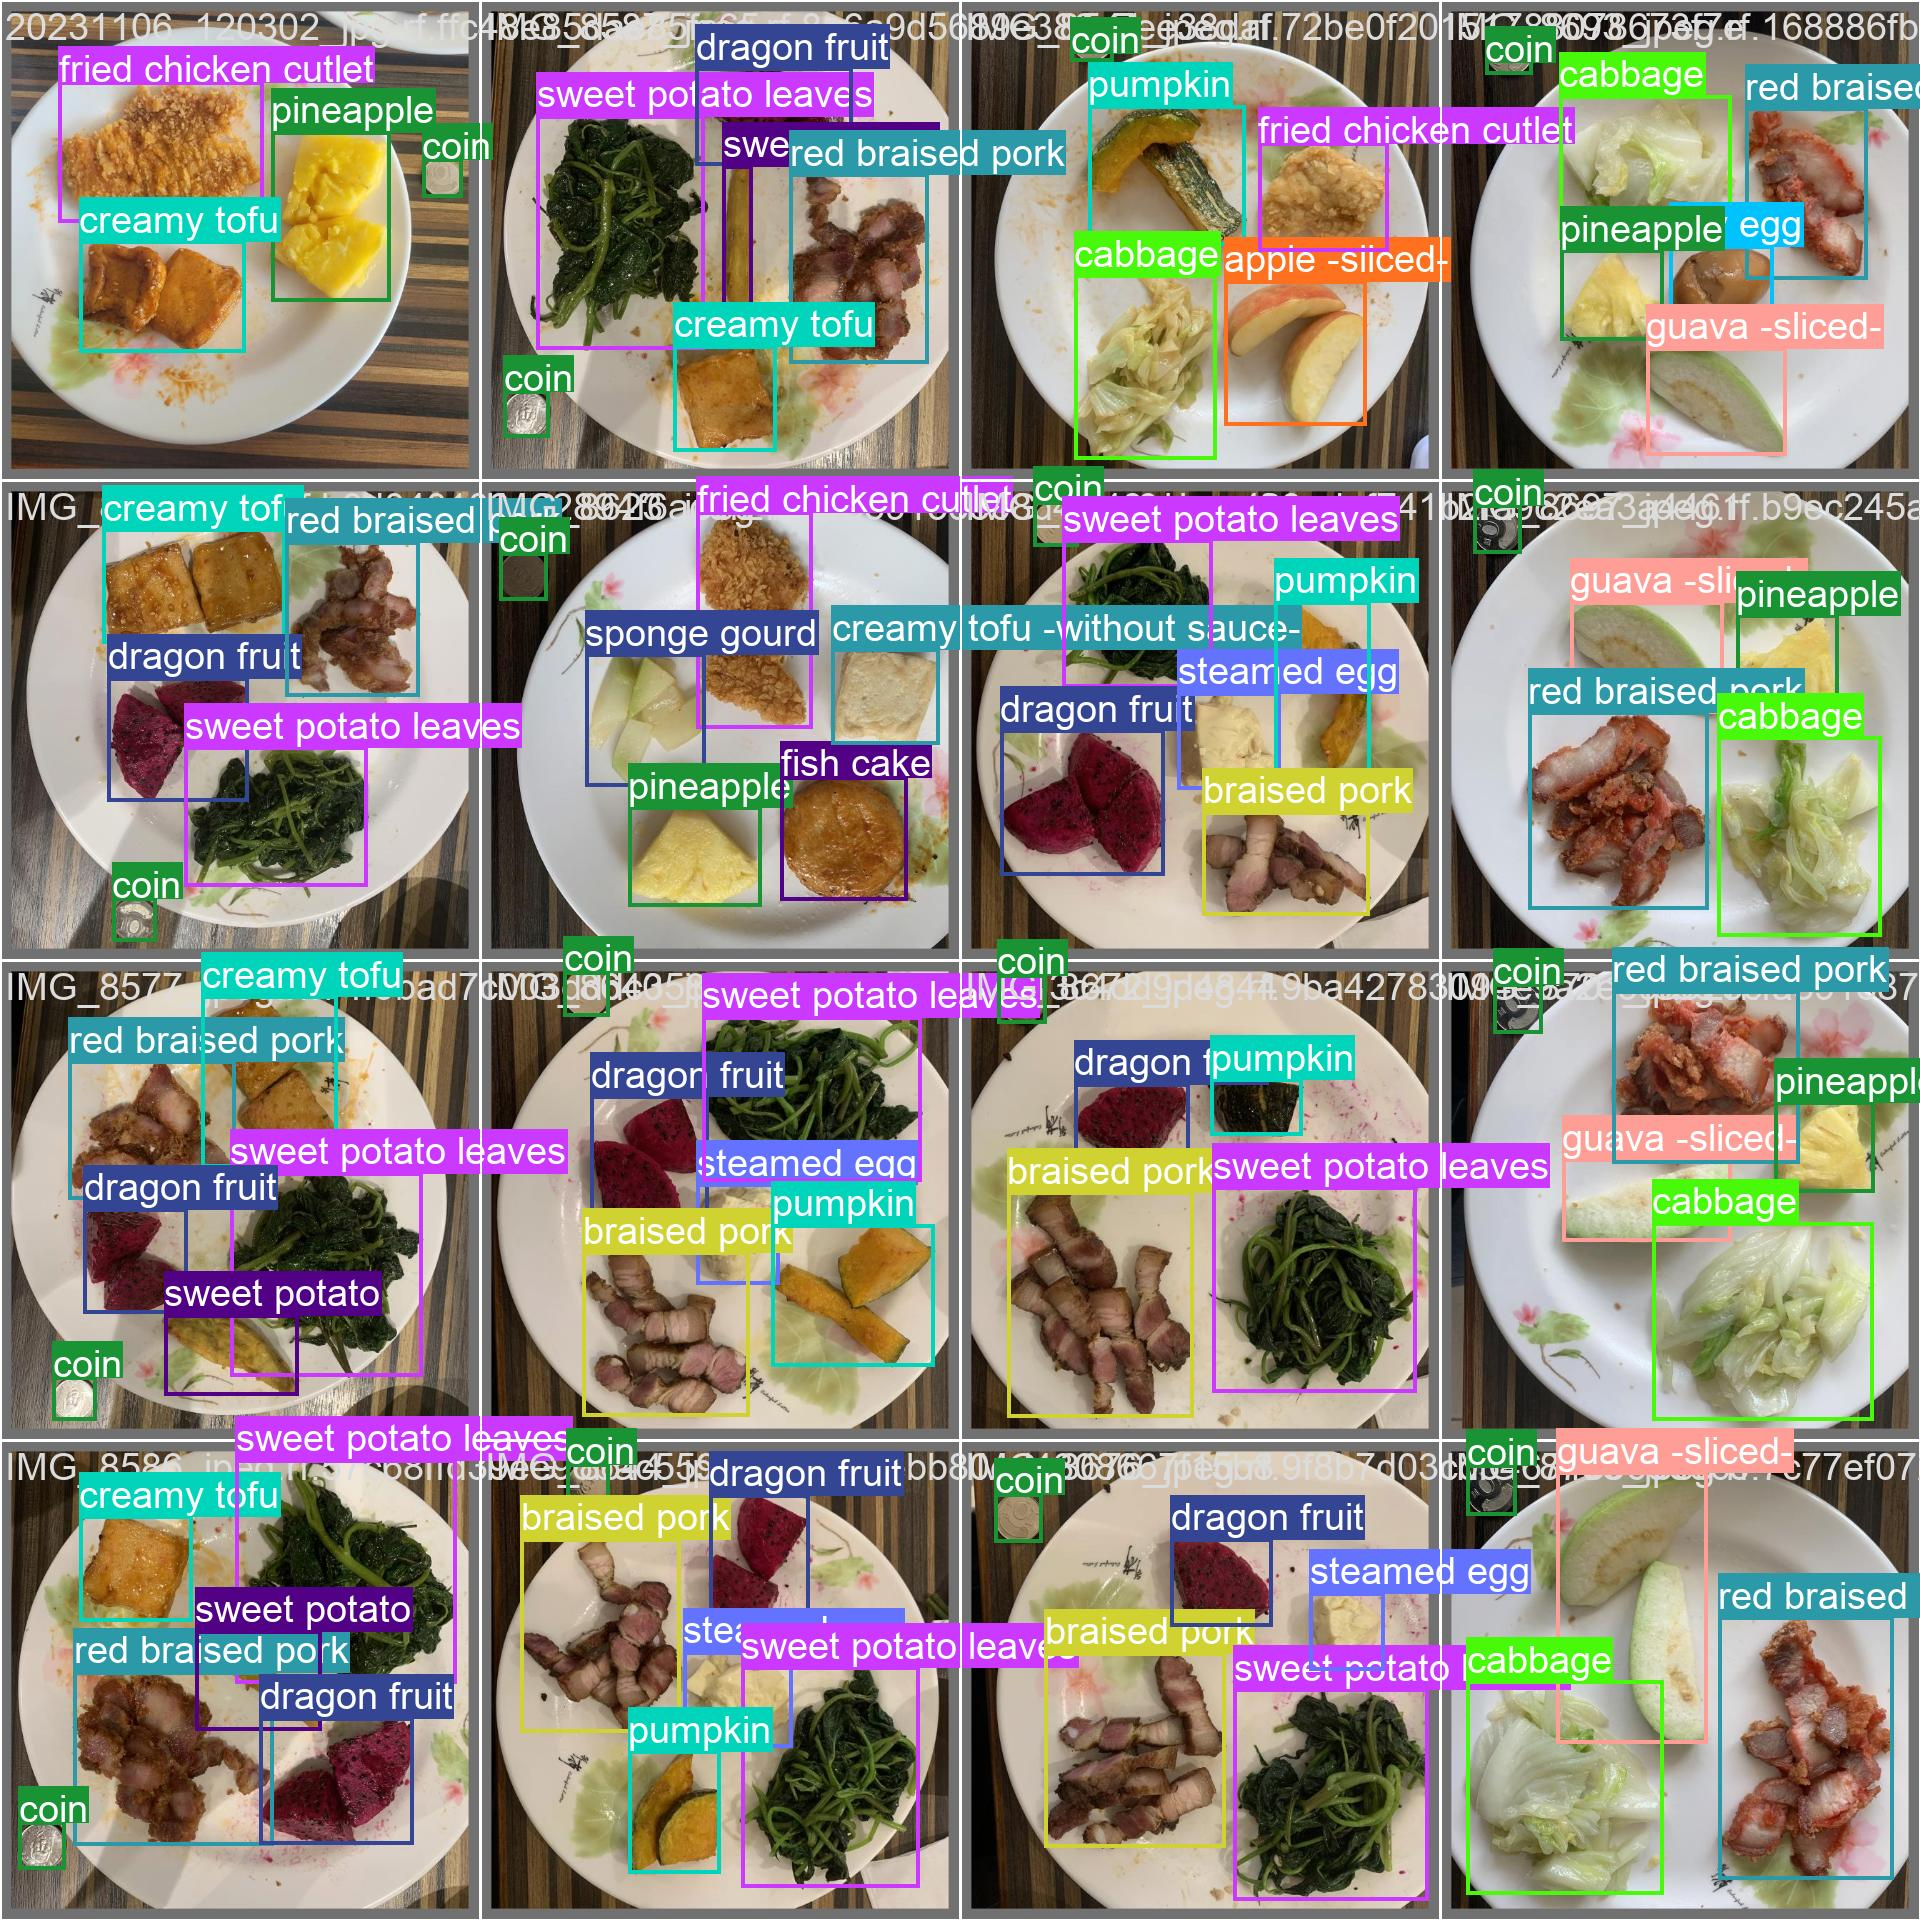

In [15]:
Image(filename='./runs/train/yolov5s_results/val_batch0_labels.jpg', width=900)

GROUND TRUTH AUGMENTED TRAINING DATA:


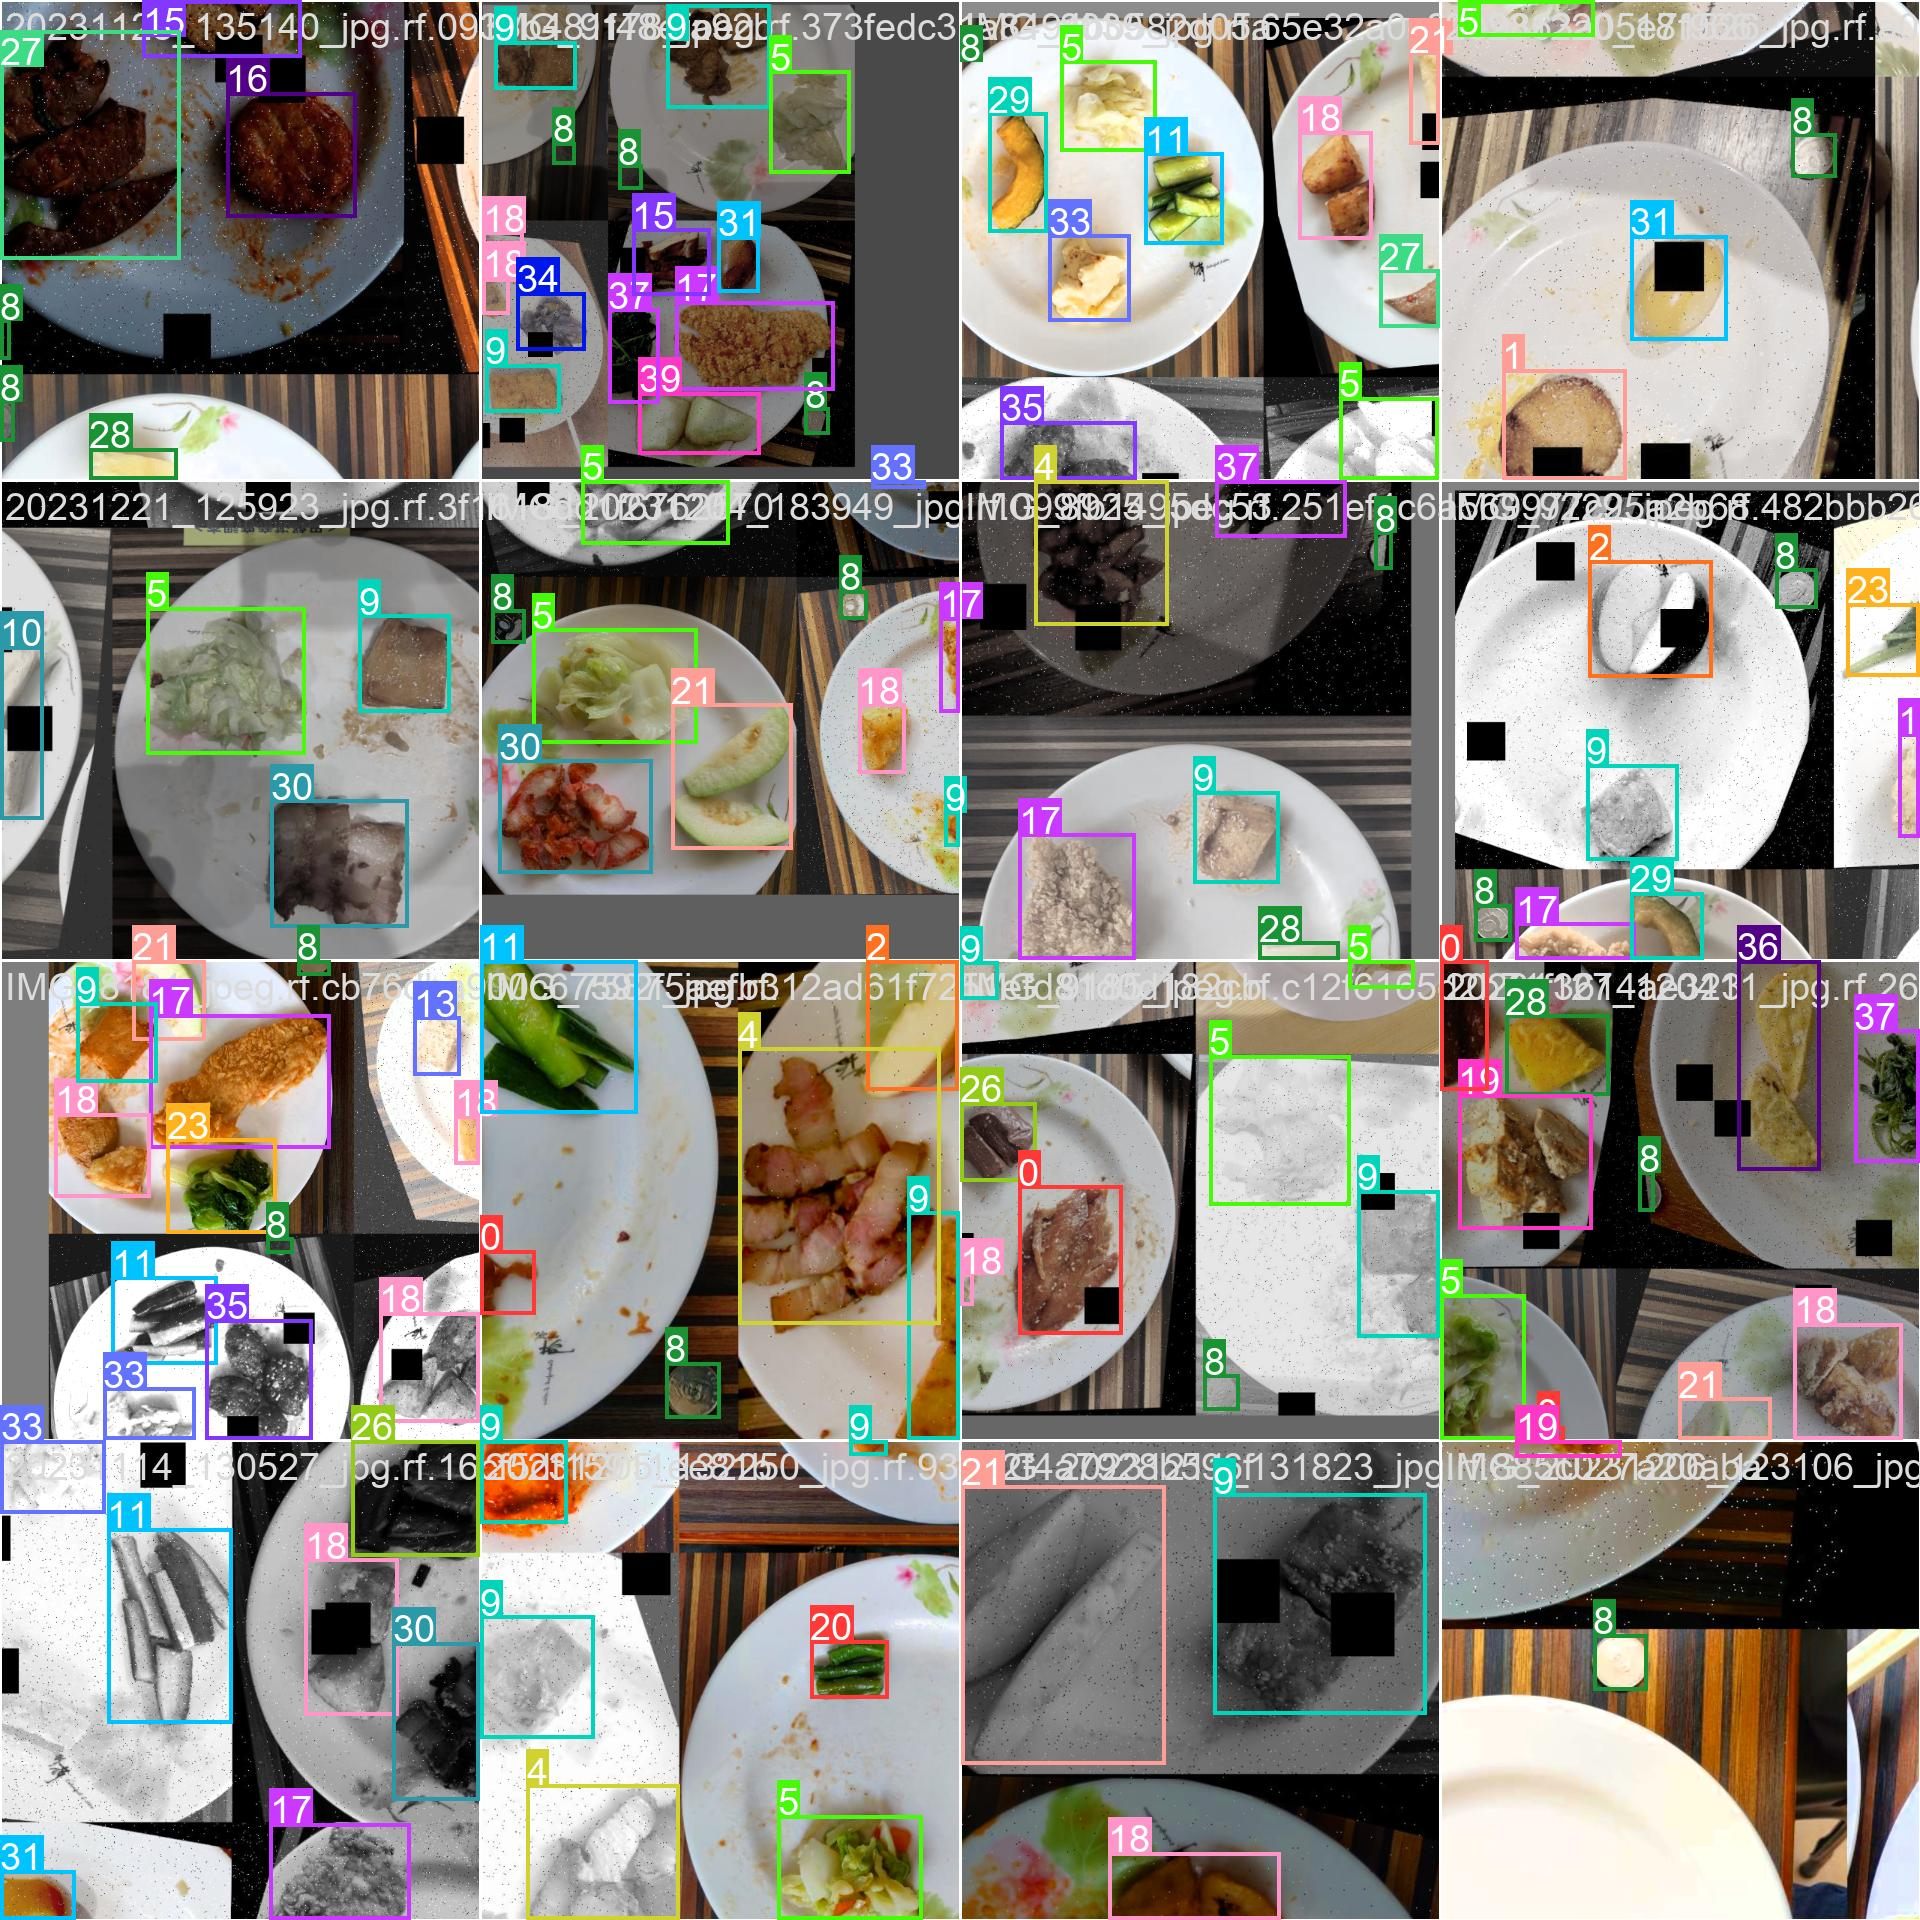

In [16]:
# print out an augmented training example
print("GROUND TRUTH AUGMENTED TRAINING DATA:")
Image(filename='./runs/train/yolov5s_results/train_batch0.jpg', width=900)

# Run Inference With Trained Weights

Next, we can run inference with a pretrained checkpoint on all images in the `test/images` folder to understand how our model performs on our test set.

In [17]:
# trained weights are saved by default in our weights folder
%ls runs/

train/


In the snippet below, replace `Cash-Counter-10` with the name of the folder in which your dataset is stored.

In [18]:
%pwd
%ls Food-{DATASET_VERSION}

data.yaml  README.dataset.txt  README.roboflow.txt  test/  train/  valid/


In [19]:
#%cd /content/yolov5/
!python detect.py --weights ./runs/train/yolov5s_results/weights/best.pt --img 640 --conf 0.4 --source ./Food-{DATASET_VERSION}/test/images/

detect: weights=['./runs/train/yolov5s_results/weights/best.pt'], source=./Food-15/test/images/, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-72-g064365d Python-3.10.13 torch-2.1.2+cu121 CUDA:0 (NVIDIA GeForce RTX 3060, 12044MiB)

Fusing layers... 
custom_YOLOv5s summary: 182 layers, 7351701 parameters, 0 gradients
image 1/164 /calorie/Ipynb_Files/yolov5/Food-15/test/images/20231106_115308_jpg.rf.1767faa5ab150f7b9999e51e59515919.jpg: 640x640 1 coin, 1 fried chicken cutlet, 1 pineapple, 4.7ms
image 2/164 /calorie/Ipynb_Files/yolov5/Food-15/test/images/20231106_120600_jpg.rf.2701dd430655dc1d1c745b1a3f7dfc2a.jpg: 640x640 1 Kabayaki 

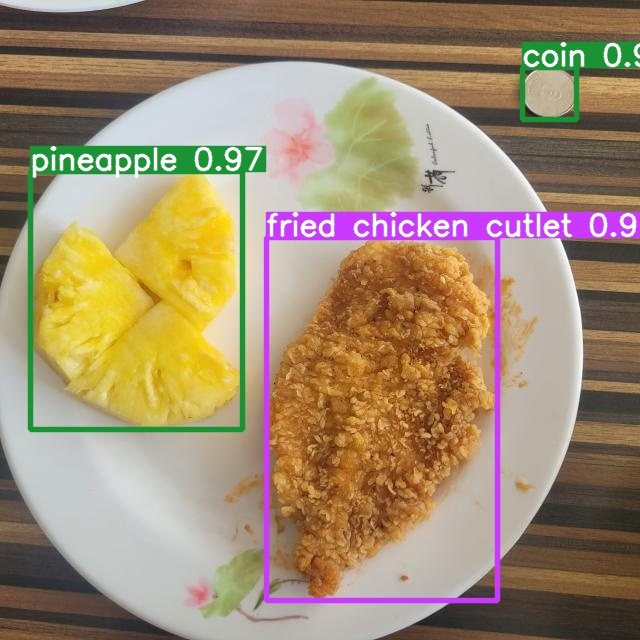

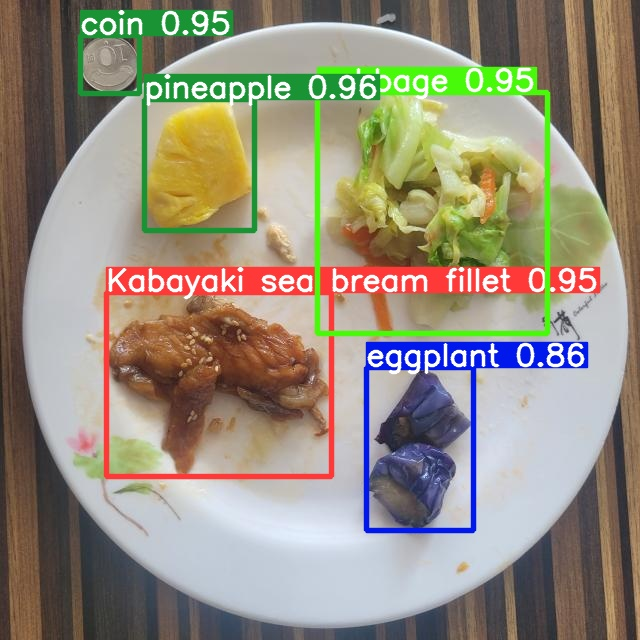

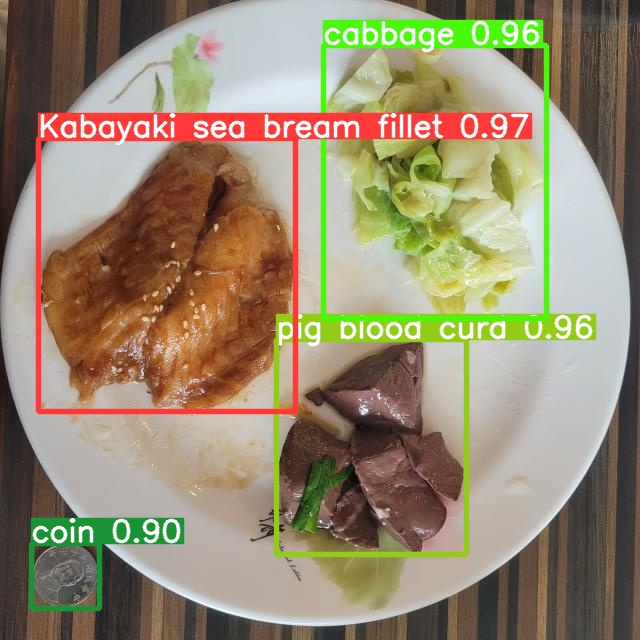

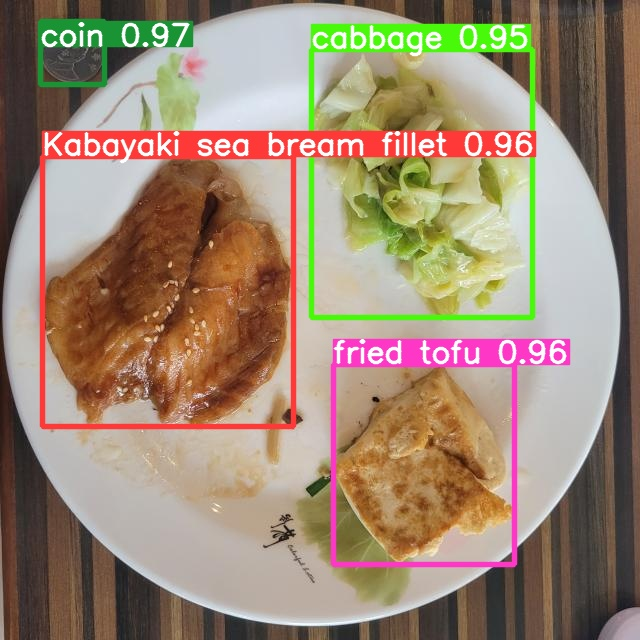

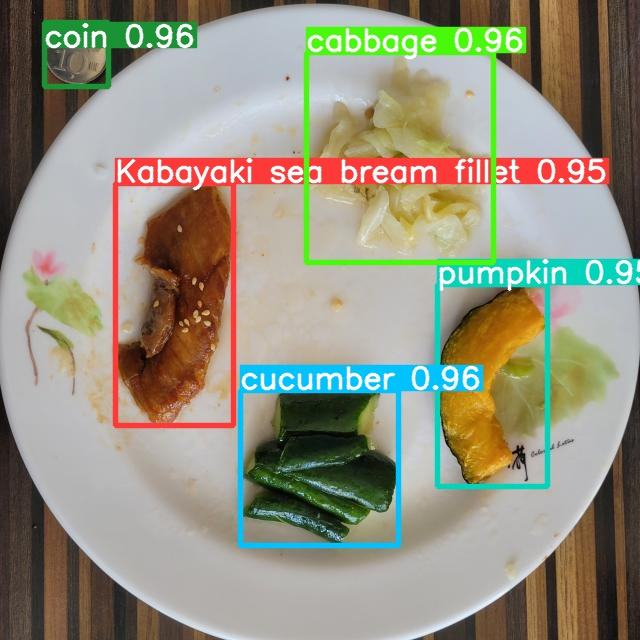

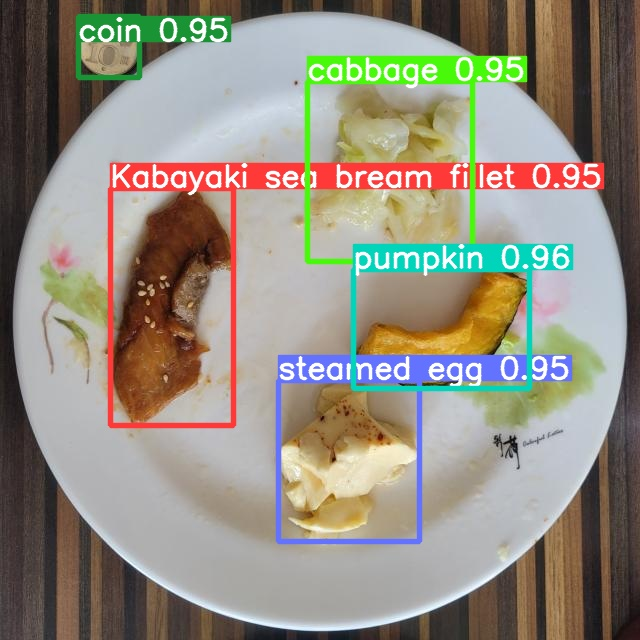

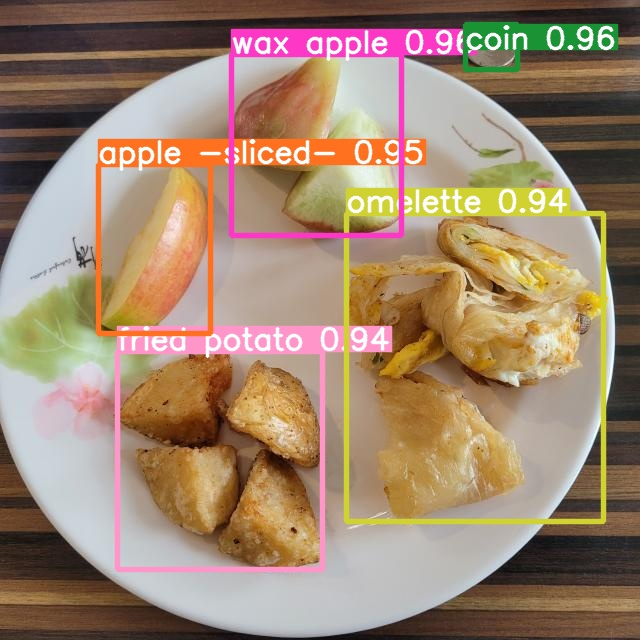

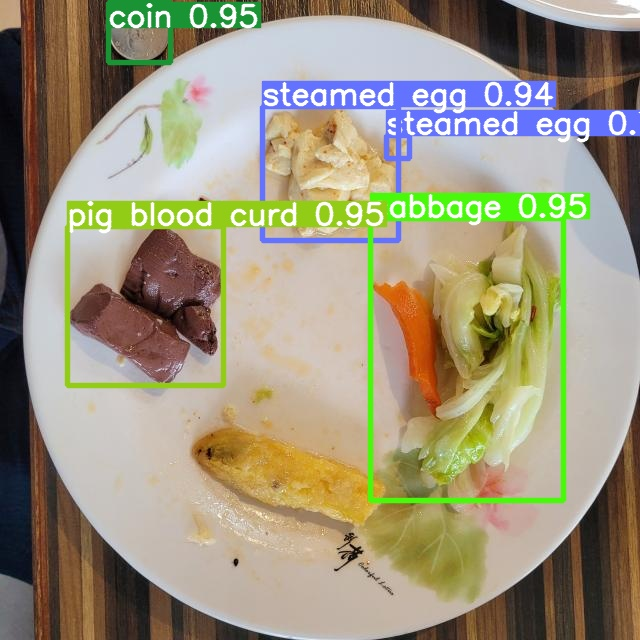

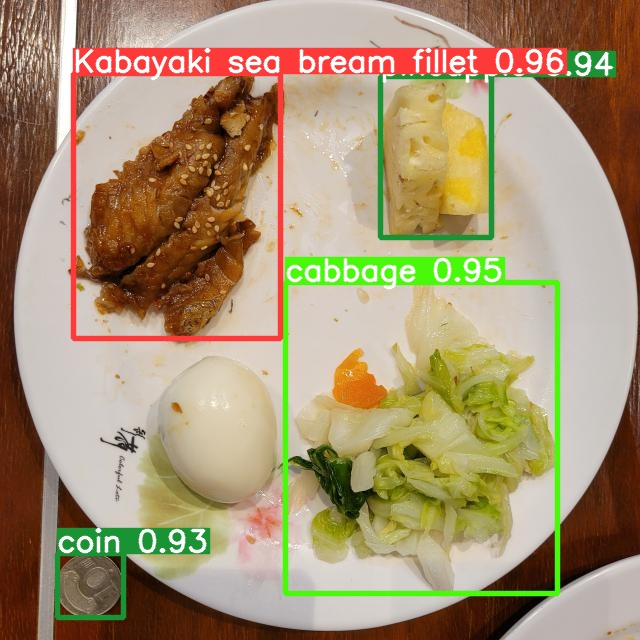

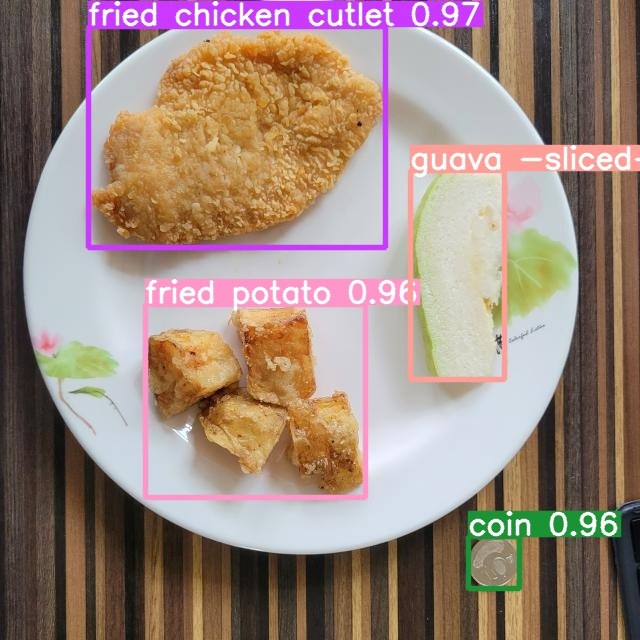

In [20]:
import glob
from IPython.display import Image, display

for imageName in glob.glob('./runs/detect/exp/*.jpg')[:10]: #assuming JPG
    display(Image(filename=imageName))

## Deploy Model on Roboflow

Once you have finished training your YOLOv8 model, you’ll have a set of trained weights ready for use. These weights will be in the `/content/yolov5/runs/train/yolov5s_results/` folder of your project. You can upload your model weights to Roboflow Deploy to use your trained weights on our infinitely scalable infrastructure.

The `.deploy()` function in the [Roboflow pip package](https://docs.roboflow.com/python) now supports uploading YOLOv8 weights.

**Before you run this code, make sure you create a new Version in the Roboflow dashboard following the instructions we covered earlier. Fill in your project name, workspace, and version number below.**

To upload model weights, add the following code to the “Inference with Custom Model” section in the aforementioned notebook:

In [21]:
rf = Roboflow(api_key="lttzJNap0h9lODifvr4O")
project = rf.workspace("school-yrws4").project("food-pion4")
dataset = project.version(DATASET_VERSION).download("yolov5")


project.version(dataset.version).deploy(model_type="yolov5", model_path=f"./runs/train/yolov5s_results/")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Food-15 in yolov5pytorch::  34%|███▎      | 3044/9020 [00:00<00:01, 4049.07it/s]

Extracting Dataset Version Zip to Food-15 in yolov5pytorch:: 100%|██████████| 9020/9020 [00:02<00:00, 3257.88it/s]


View the status of your deployment at: https://app.roboflow.com/school-yrws4/food-pion4/15
Share your model with the world at: https://universe.roboflow.com/school-yrws4/food-pion4/model/15


In [22]:
#Run inference on your model on a persistant, auto-scaling, cloud API

#load model
model = project.version(dataset.version).model

#choose random test set image
import os, random
test_set_loc = dataset.location + "/test/images/"
random_test_image = random.choice(os.listdir(test_set_loc))
print("running inference on " + random_test_image)

pred = model.predict(test_set_loc + random_test_image, confidence=40, overlap=30).json()
pred

running inference on IMG_20231211_130831_jpg.rf.6d9cd2e810b16e0ee0549040b7f359e6.jpg


HTTPError: 403 Client Error: Forbidden for url: https://detect.roboflow.com/food-pion4/15?api_key=lttzJNap0h9lODifvr4O&name=YOUR_IMAGE.jpg&overlap=30&confidence=40&stroke=1&labels=false&format=json

# Deploy Your Model to the Edge

In addition to using the Roboflow hosted API for deployment, you can use [Roboflow Inference](https://inference.roboflow.com), an open source inference solution that has powered millions of API calls in production environments. Inference works with CPU and GPU, giving you immediate access to a range of devices, from the NVIDIA Jetson to TRT-compatible devices to ARM CPU devices.

With Roboflow Inference, you can self-host and deploy your model on-device. You can deploy applications using the [Inference Docker containers](https://inference.roboflow.com/quickstart/docker/) or the pip package.

For example, to install Inference on a device with an NVIDIA GPU, we can use:

```
docker pull roboflow/roboflow-inference-server-gpu
```

Then we can run inference via HTTP:

```python
import requests

workspace_id = ""
model_id = ""
image_url = ""
confidence = 0.75
api_key = ""

infer_payload = {
    "image": {
        "type": "url",
        "value": image_url,
    },
    "confidence": confidence,
    "iou_threshold": iou_thresh,
    "api_key": api_key,
}
res = requests.post(
    f"http://localhost:9001/{workspace_id}/{model_id}",
    json=infer_object_detection_payload,
)

predictions = res.json()
```

Above, set your Roboflow workspace ID, model ID, and API key.

- [Find your workspace and model ID](https://docs.roboflow.com/api-reference/workspace-and-project-ids?ref=blog.roboflow.com)
- [Find your API key](https://docs.roboflow.com/api-reference/authentication?ref=blog.roboflow.com#retrieve-an-api-key)

Also, set the URL of an image on which you want to run inference. This can be a local file.

_To use your YOLOv5 model commercially with Inference, you will need a Roboflow Enterprise license, through which you gain a pass-through license for using YOLOv5. An enterprise license also grants you access to features like advanced device management, multi-model containers, auto-batch inference, and more._

## 🏆 Congratulations

### Learning Resources

Roboflow has produced many resources that you may find interesting as you advance your knowledge of computer vision:

- [Roboflow Notebooks](https://github.com/roboflow/notebooks): A repository of over 20 notebooks that walk through how to train custom models with a range of model types, from YOLOv7 to SegFormer.
- [Roboflow YouTube](https://www.youtube.com/c/Roboflow): Our library of videos featuring deep dives into the latest in computer vision, detailed tutorials that accompany our notebooks, and more.
- [Roboflow Discuss](https://discuss.roboflow.com/): Have a question about how to do something on Roboflow? Ask your question on our discussion forum.
- [Roboflow Models](https://roboflow.com): Learn about state-of-the-art models and their performance. Find links and tutorials to guide your learning.

### Convert data formats

Roboflow provides free utilities to convert data between dozens of popular computer vision formats. Check out [Roboflow Formats](https://roboflow.com/formats) to find tutorials on how to convert data between formats in a few clicks.

### Connect computer vision to your project logic

[Roboflow Templates](https://roboflow.com/templates) is a public gallery of code snippets that you can use to connect computer vision to your project logic. Code snippets range from sending emails after inference to measuring object distance between detections.